**Table of contents**<a id='toc0_'></a>    
- 1. [AS-AD for an open economy](#toc1_)    
- 2. [Analytical solution](#toc2_)    
- 3. [Numerical solution and calibration of model](#toc3_)    
- 4. [Further analysis (ideas)](#toc4_)    
- 5. [Conclusion](#toc5_)    


In [1]:
%load_ext autoreload
%autoreload 2

from types import SimpleNamespace
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

from test_chris import ASADClass 

## 1. <a id='toc1_'></a>[AS-AD for an open economy](#toc0_)


Define the **output and inflation gaps**:


1. **Output:** $$\hat{y}_{t} = y_t-\bar{y}$$
2. **Inflation:** $$\hat{\pi}_{t} = \pi_t-\pi^{\ast}$$


1. **AD-curve:** $$\hat{y}_{t} = \beta_1 (e^r_{t-1}-\hat{\pi}_{t}) + z_t$$
2. **Short-Run AS curve:** $$\hat{\pi}_{t} = \gamma \hat{y}_{t}+ s_t$$
3. **Real Exchange rate:** $$ e^r_t = e^r_{t-1}-\hat{\pi}_{t}$$



**After a bit of algebra...** and with no shocks then the model can be written as


$$
\begin{aligned}
\hat{y}_{t} & = \frac{1}{1+\beta_1\gamma}\hat{y}_{t-1}
\end{aligned}
$$


In **business-cycle data** from the US/Denmark we have:
* Change data to denmark
1. $std(\hat{y}_t) = 1.64$
2. $std({\hat{\pi}}_t) = 0.21$
3. $corr(\hat{y}_t,{\hat{\pi}}_t) = 0.31$
4. $corr(\hat{y}_t,\hat{y}_{t-1}) = 0.84$
5. $corr({\hat{\pi}}_t,{\hat{\pi}}_{t-1}) = 0.48$

**Task:**

1. Assume you have external evidence that $\alpha = 0.7$, $\gamma = 0.075$ and $\phi = 0.99$
2. Can you choose the remaining parameter so the model matches the data?

In [2]:
model = ASADClass()
par = model.par
sim = model.sim
print(f'{par.a = :.4f}')
print(f'{par.beta = :.4f}')

par.a = 0.9995
par.beta = 0.9501


## 3. <a id='toc3_'></a>[Simulate](#toc0_)

In [6]:
model.simulate()

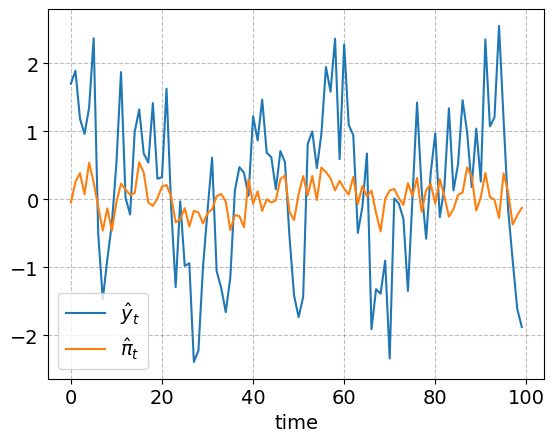

In [7]:
simT_fig = 100 # first 100 periods
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(simT_fig),sim.y_hat[:simT_fig],label='$\\hat{y}_t$')
ax.plot(np.arange(simT_fig),sim.pi_hat[:simT_fig],label='$\\hat{\pi}_t$')
ax.set_xlabel('time')
ax.legend(frameon=True);

In [18]:
model.calc_moms() # calculate moments from the simulation
error = model.calc_diff_to_data(do_print=True) # compares with the data

std_y       | data = 1.6400, model = 1.5735
std_pi      | data = 0.2100, model = 0.2596
corr_y_pi   | data = 0.3100, model = 0.3758
autocorr_y  | data = 0.8400, model = 0.7873
autocorr_pi | data = 0.4800, model = 0.4934
error =   0.01417315


In [17]:
(1.64-1.5735)**2+ (0.21-0.2596)**2 + (0.31-0.3758)**2+(0.84-0.7873)**2+(0.48-0.4934)**2

0.014168900000000002

We now consider a **structural estimation**. 

**Principle:** Choose parameters to minimize the distance between data moments and simulated model moments.

**Objective:** A measure of the distance between model and data (involves a subjective choice of moments), here:

$$
\begin{align*}
g(\delta,\omega,\sigma_x,\sigma_c) = &\,\,(std(\hat{y}_t^{data}) - std(\hat{y}_t^{model}))^2 \\
& + (std({\hat{\pi}}_t^{data}) - std({\hat{\pi}}_t^{model}))^2 \\
& + (corr(\hat{y}_t^{data},{\hat{\pi}}_t^{data}) - corr(\hat{y}_t^{data},{\hat{\pi}}_t^{model}))^2 \\
& + (corr(\hat{y}_t^{data},\hat{y}_{t-1}^{data}) - corr(\hat{y}_t^{model},\hat{y}_{t-1}^{model}))^2 \\
& + (corr({\hat{\pi}}_t^{data},{\hat{\pi}}_{t-1}^{data}) - corr({\hat{\pi}}_t^{model},{\hat{\pi}}_{t-1}^{model}))^2 \\
\end{align*}
$$

**Minimization:** Choose the free parameters to minimize the objective, i.e.

$$
\min_{\delta,\omega,\sigma_x,\sigma_c} g(\delta,\omega,\sigma_x,\sigma_c)
$$

In [20]:
def obj(x,parnames,do_print=False):
    """ objective for choosing parameters """

    # a. update parameters
    for xval,parname in zip(x,parnames):
        par.__dict__[parname] = xval
        if do_print: print(f'{parname:10s} = {xval:.4f}')

    if do_print: print('')

    model.calc_compound_par()

    # b. simulate and calculate moments
    model.simulate()
    model.calc_moms()

    # c. compare with data
    error = model.calc_diff_to_data(do_print=do_print)

    return error

**Calculate objective at initial values:**

In [21]:
parnames = ['delta','omega','sigma_x','sigma_c']
x0 = [par.__dict__[parname] for parname in parnames]
error_ = obj(x0,parnames,do_print=True)

delta      = 0.8000
omega      = 0.1500
sigma_x    = 1.0000
sigma_c    = 0.2000

std_y       | data = 1.6400, model = 1.5735
std_pi      | data = 0.2100, model = 0.2596
corr_y_pi   | data = 0.3100, model = 0.3758
autocorr_y  | data = 0.8400, model = 0.7873
autocorr_pi | data = 0.4800, model = 0.4934
error =   0.01417315


**Estimate:**

In [22]:
bounds = ((0,1-1e-8),(0,1-1e-8),(0,None),(0,None))
res = optimize.minimize(obj,x0,bounds=bounds,method='Nelder-Mead',args=(parnames,))

In [23]:
assert res.success

In [24]:
error_ = obj(res.x,parnames,do_print=True)

delta      = 0.8477
omega      = 0.1009
sigma_x    = 0.9211
sigma_c    = 0.2209

std_y       | data = 1.6400, model = 1.6268
std_pi      | data = 0.2100, model = 0.2852
corr_y_pi   | data = 0.3100, model = 0.3458
autocorr_y  | data = 0.8400, model = 0.8329
autocorr_pi | data = 0.4800, model = 0.4802
error =   0.00716134


## 3. <a id='toc3_'></a>[Numerical solution and calibration of model](#toc0_)

## 4. <a id='toc4_'></a>[Further analysis (ideas)](#toc0_)

Impulse response to demand or supply shock. Errors are zero for all t.

Difference between y and y_hat for periods 1 to T. 

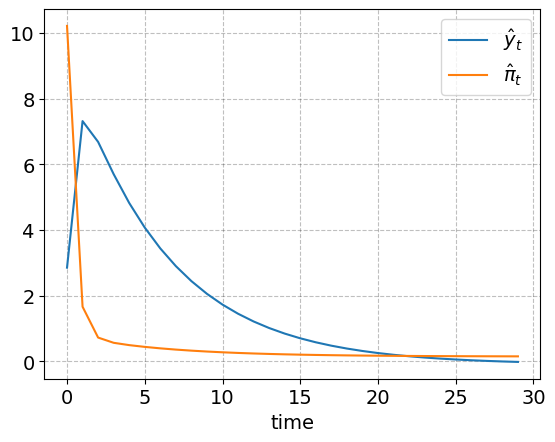

In [33]:
model.impulse_response(supply=True)
simT_fig = 30 # first 100 periods
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(simT_fig),sim.y_hat[:simT_fig],label='$\\hat{y}_t$')
ax.plot(np.arange(simT_fig),sim.pi_hat[:simT_fig],label='$\\hat{\pi}_t$')
ax.set_xlabel('time')
ax.legend(frameon=True);

## 5. <a id='toc5_'></a>[Conclusion](#toc0_)